# Gradientenverfahren

## Imports

In [1]:
import pandas as pd
import numpy as np
from time import time
import random 
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

## Generate Data

Wir generieren einen unabhängigen Inputdatensatz $\mathbf x$  bestehend aus 1.000 Instanzen mit je 2 Attributen sowie einem abhängigen Target $y$, welches sich aus $\mathbf x$ zusammensetzt nach folgender Form:<br>
$y = 2.5x_{1}+2.5x{_2}$<br>
Aufgabe eines zu implementierenden Optimierungsverfahrens ist es das zugrundeliegende Muster (= die Gewichte ([2.5,2.5])) möglichst effizient zu finden.

In [2]:
x = np.random.uniform(-1,1,(1000,2))
y = np.sum(x*2.5,axis=1).reshape(-1,1)
y += 0.4*np.random.uniform(-1,1,(1000,1))
w_real = np.array([2.5,2.5]).reshape(-1,1)

Um näher den meisten Lehrbüchern zu sein behandeln wir $\mathbf w$ als Spaltenvektor, daher das `.reshape(-1,1)`

## Plot Data

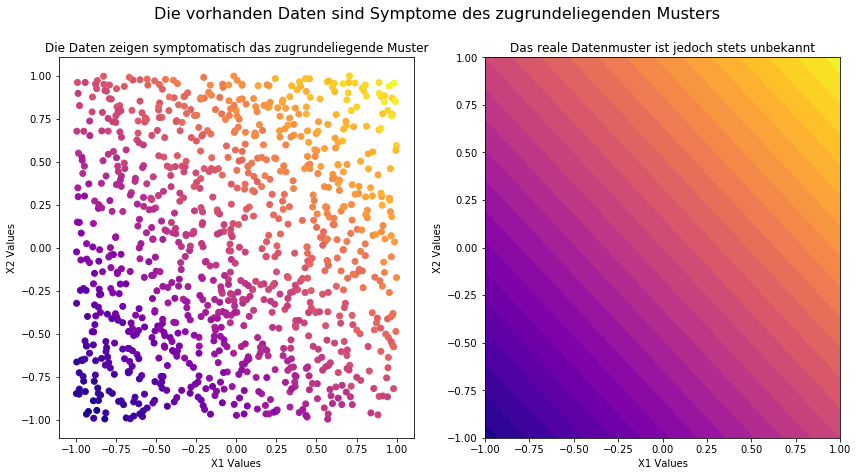

In [3]:
# Plot
fig = plt.figure(figsize=(14,7))
fig.suptitle("Die vorhanden Daten sind Symptome des zugrundeliegenden Musters", fontsize=16)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

# Scatter
ax1.scatter(x[:,:1],x[:,1:],c=y,cmap=cm.plasma)
## Plot beschreiben
ax1.set_title("Die Daten zeigen symptomatisch das zugrundeliegende Muster")
ax1.set_xlabel("X1 Values")
ax1.set_ylabel("X2 Values")

# Gradient
x1,x2 = np.meshgrid(np.linspace(-1,1),np.linspace(-1,1))
z = x1*2.5+x2*2.5
ax2.contourf(x1,x2,z,cmap=cm.plasma,levels=30)
## Plot beschreiben
ax2.set_title("Das reale Datenmuster ist jedoch stets unbekannt")
ax2.set_xlabel("X1 Values")
ax2.set_ylabel("X2 Values")

fig.show()

## Von Daten auf das Muster schließen

Wir können versuchen von den Daten auf das Muster zu schließen. Grundannahme ist, dass die Daten ($x_{1}$ und $x_{2}$) mit dem Target ($y$) in Beziehung stehen und $y$ nicht randomisiert ist. Das Muster wird ausgedrückt durch Gewichte ($w_{1}$ und $w_{2}$), sodass eine Prädiktion $\hat{y} = x_{1}w_{1}+x_{2}w_{2}$ stets möglichst ähnlich ist zu $y$. Für die Klarheit der Notation: $\hat{y} = x_{1}w_{1}+x_{2}w_{2} = \mathbf x \mathbf w$. Zufällige Werte für $w_{1}$ und $w_{2}$ resultiert in ein Muster.

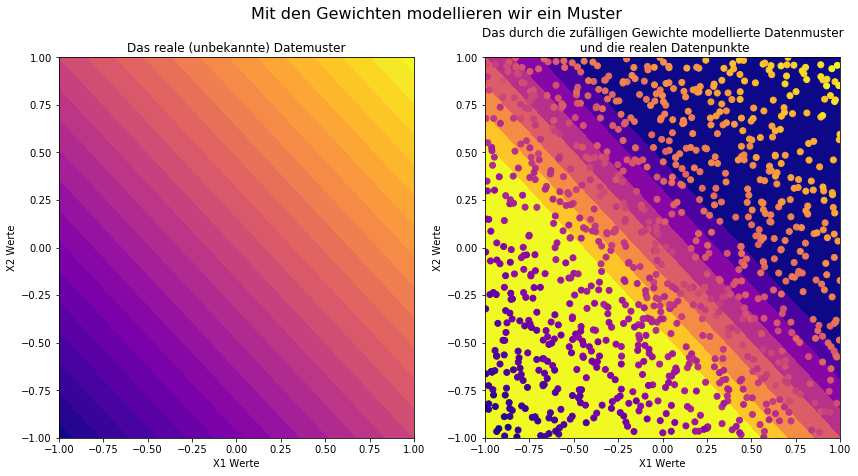

In [4]:
w_random = np.array([-10,15]).reshape(-1,1)

# Plot
fig = plt.figure(figsize=(14,7))
fig.suptitle("Mit den Gewichten modellieren wir ein Muster", fontsize=16)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
x1,x2 = np.meshgrid(np.linspace(-1,1),np.linspace(-1,1))


# Reales Muster
z = x1*w_real[0]+x2*w_real[0]
ax1.contourf(x1,x2,z,cmap=cm.plasma,levels=30,vmin=-5,vmax=5)
## Plot beschreiben
ax1.set_title("Das reale (unbekannte) Datemuster")
ax1.set_xlabel("X1 Werte")
ax1.set_ylabel("X2 Werte")

# Random Werte für W
z = x1*w_random[0]+x2*w_random[0]
ax2.contourf(x1,x2,z,cmap=cm.plasma,levels=30,vmin=-5,vmax=5)
## Plot beschreiben
ax2.set_title("Das durch die zufälligen Gewichte modellierte Datenmuster\n und die realen Datenpunkte")
ax2.set_xlabel("X1 Werte")
ax2.set_ylabel("X2 Werte")
ax2.set_xlim([-1,1])
ax2.set_ylim([-1,1])
ax2.scatter(x[:,:1],x[:,1:],c=y,cmap=cm.plasma)

fig.show()

Mit Hilfe des generierten Datenmusters (basierend auf $w_{1}$ und $w_{2}$) kann nun eine Abweichung zwischen dem Vorhergesagten Wert (quasi "Farbwert", in diesem Fall) $\hat{y}$  und dem realen, bekannten Wert $y$ aus dem Daten generiert Werten. Die Abweichung zwischen diesen Werten ist der Fehler, den $w_{1}$ und $w_{2}$ verursacht haben. Die Fehlerfunktion kann dabei beispielsweise so aussehen:<br>
$r(x) = \sum \limits _{j=1} ^{p}(\mathbf{x}\mathbf{w} -y)^2$
<br><br>
wobei $\mathbf{w}$ der Gewichtsvektor ist, $\mathbf{x}$ ist der Inputvektor und $y$ ist das Target. $\mathbf{x}$ ist äquivalent zu $\hat{y}$. Die hier gewählte Fehlerfunktion (Cost Function, Error Function) heißt *Summed Squared Error*

## Summed Squared Error für die randomisiert gewählten Gewichte

In [5]:
def sse(x,w,y):
    return np.mean((np.dot(x,w).reshape(-1,1)-y)**2)


print("Der SSE für die randomisierten Gewicht ist {}".format(sse(x,w_random,y)))
print("Der SSE für die optimalen Gewicht ist {}".format(sse(x,w_real,y)))

Der SSE für die randomisierten Gewicht ist 99.95501936584459
Der SSE für die optimalen Gewicht ist 0.053721878898656344


## Die Gewichte und der daraus resultierende Fehler kann als Landschaft (Distribution) dargestellt werden

Zu diesem Zweck muss entlang eines zweidimensionalen Raumes (da zwei Gewichte für zwei Input Werte existieren) der Fehler $r(x)$ für jede Kombination von Werten für die Gewichte $w_{1}$ und $w_{2}$ errechnet werden.

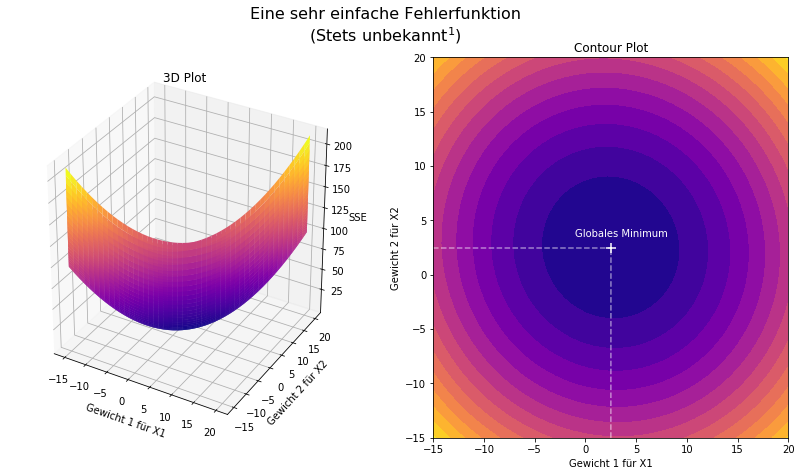

In [6]:
error_surface = []
# Die Grenzen der Gewichte definieren
w1_space, w2_space = np.linspace(-15,20), np.linspace(-15,20)

# jede Gewichtskombination durchlaufen
for w2 in w2_space:
    for w1 in w1_space:
        # den sse für diese Werte speichern
        error_surface.append(sse(x,np.array([w1,w2]),y))
    
# die Oberfläche zu einem Quadrat Formen
error_surface = np.array(error_surface).reshape(50,50)

# Plot initialisieren
fig = plt.figure(figsize=(14,7))
fig.suptitle("Eine sehr einfache Fehlerfunktion\n(Stets unbekannt$^1$)", fontsize=16)
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122)

# 3 dimensionale Ansicht darstellen
ax1.plot_surface(w1_space,w2_space,error_surface, cmap=cm.plasma)
## Plot beschreiben
ax1.set_xlabel("Gewicht 1 für X1")
ax1.set_ylabel("Gewicht 2 für X2")
ax1.set_zlabel("SSE")
ax1.set_title("3D Plot")

# Contour Plot
ax2.contourf(w1_space,w2_space,error_surface, cmap=cm.plasma,levels=20)
## Globales Minimum einfügen
ax2.scatter(2.5,2.5, marker="+",c="w",s=100)
ax2.text(-1,3.5,"Globales Minimum",c="w")
ax2.plot([-15,2.5],[2.5,2.5],ls="--",c="w",alpha=0.5)
ax2.plot([2.5,2.51],[-15,2.51],ls="--",c="w",alpha=0.5)
## Plot beschreiben
ax2.set_xlabel("Gewicht 1 für X1")
ax2.set_ylabel("Gewicht 2 für X2")
ax2.set_title("Contour Plot")

fig.show()

***

$^1$ Die Fehlerdistribution ist tatsächlich nicht unbekannt, obwohl man dies ständig sagt.<br>Sie ist sogar komplett verfügbar, wenn Daten ($\mathbf{x}$ und $y$), Modell ($\mathbf{x}\mathbf{w}$) und die Cost Function ($r(x) = \sum \limits _{j=1} ^{p}(\hat{y}-y)^2$) verfügbar sind.<br>
Es muss lediglich für jeden möglichen Wert von $w_{1}$ und $w_{2}$ (wenn es nur zwei Input Werte gibt) innerhalb eines gegebenen Intervalls der Fehler errechnet werden. Jedoch ist dies für komplexer Modelle und umfangreichere Daten so rechenaufwändig (potenziell Jahre), dass die komplette Fehlerdistribution nicht vorliegt. Dies ist gemeint, wenn gesagt wird *die Fehlerdistribution ist unbekannt*, auch wenn Sie ist natürlich faktisch nicht ist. Für weitere Vertiefung siehe <a href="https://medium.com/@DBCerigo/on-why-gradient-descent-is-even-needed-25160197a635" target="_blank">diesen Artikel</a>.

***

## Wie finden wir die richten Gewichte für die stets korrekte Vorhersage?

Mit dem Gradient Descent. Das Gradientenverfahren (engl. *Gradient Descent* = "Gradieller Abstieg") erlaubt ein iteratives *suchen* nach den Parameten (=Gewichten $\mathbf{w}$) eines Modells ($\mathbf{x}\mathbf{w} $), sodass der Vorhersagefehler ($r(x)$ bzw. SSE) minimiert wird (*\"iteratives suchen\"* = *optimieren*).<br>

Dazu wird die Error Funktion <br><br>
$r(x) = \sum \limits _{j=1} ^{p}(\mathbf{x}_{j}\mathbf{w}_{j} -y_{j})^2$<br><br>
abgeleitet nach allen Stellschrauben (besser Parameter oder Gewichte), die Einfluss auf das Ergebnis von $r(x)$ haben. In unserem Fall $w_{1}$ und $w_{2}$ (oder variabel geschrieben als $w_{i}$):<br><br>
$\frac{\partial}{\partial{w_{i}}} r(x) =\sum \limits _{j=1} ^{p} 2x_{i}(\mathbf{x}_{i}\mathbf{w}_{j} -y_{j})$<br>
<font size="1">
Für eine Auffrischung, wie partielle Ableitungen gebildet werden, siehe bspw. <a href="https://www.wolframalpha.com/input/?i=d%2Fdw+%28%28%28w*x_1%2Bv*x_2%29-y%29**2%29" target="_blank">Wolfram Alpha</a>. In der Regel ist eine händische Ableitung allerdings nicht notwendig.</font><br>

Der Gradient einer partiellen Ableitung (bspw. $\frac{\partial}{\partial{w_{1}}} r(x)$) gibt an, wie sich die abgeleitete Funktion ($r(x)$) verändert, wenn $w_{1}$ verändert wird. Ist der Gradient > 0 heißt dies, dass die abgeleitete Funktion $r(x)$ größer wird, wenn $w_{1}$ größer wird. Ist der Gradient < 0 wird $r(x)$ kleiner werden, wenn $w_{1}$ größer wird.<br><br>Mit Hilfe dieser Information lässt sich die Fehlerfunktion $r(x)$ sehr einfach minimimeren. Wir ziehen vom Gewicht $w_{i}$ einfach stets den entsprechenden Gradienten ab ($\frac{\partial}{\partial{w_{1}}} r(x)$). Die Learnin Rate $\alpha$ bestimmt dabei die Länge eines Schrittes. Dadurch wird die Fehlerfunktion minimiert:<br><br>
$w_{i} := w_{i}-\alpha\frac{\partial}{\partial{w_{i}}}r(x)$<br><br>
Dies wiederholen wir so lange, bis der Fehler nicht mehr kleiner wird (dh. bis das Modell konvergiert ist). Die Anzahl an Iterationen die wir dazu erlauben nennen wir *Epochen*.



In [13]:
def gradient_descent(x,w,y,epochs=200,lr=0.00004):
    #Für Plots speichern wir alle "zwischendrin" Fehler und Gewichte
    w_history, error_history = [w],[]
    # Mehrere Epochen trainieren
    for _ in tqdm(range(epochs)):
        # Der aktuelle Fehler und das aktuelle Gewicht werden gespeichert
        error_history.append(sse(x,w,y))
        w_history.append(w)
        
        w_update = []
        # Für jedes einzelne Gewicht
        for i in range(len(w)):
            gradient = np.sum(2*x[:,i:i+1]*(np.dot(x,w).reshape(-1,1)-y))
            # das alte Gewicht w
            w_update.append(w[i]-lr * gradient)
        
        # Die alten Gewichte werden durch die neuen ersetzt
        w = np.array(w_update)

    # Optimierte Gewichte und "zwischendrin" Fehler und Gewichte zurückgeben
    return w, np.array(error_history), np.squeeze(np.array(w_history))

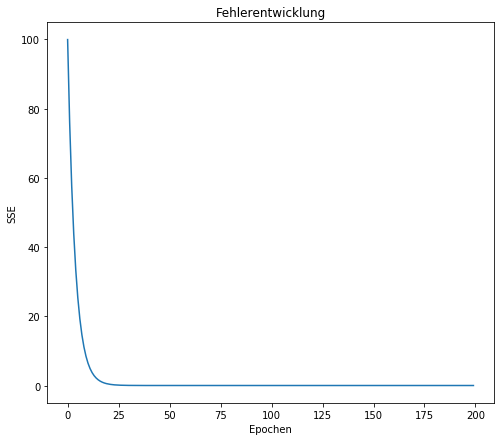

In [14]:
w_optimized, error_history, w_history = gradient_descent(x,w_random,y,lr=0.0002)

fig = plt.figure(figsize=(8,7))
plt.title("Fehlerentwicklung")
plt.xlabel("Epochen")
plt.ylabel("SSE")
plt.plot(error_history)
plt.show()

## Weight Movement in Error Surface

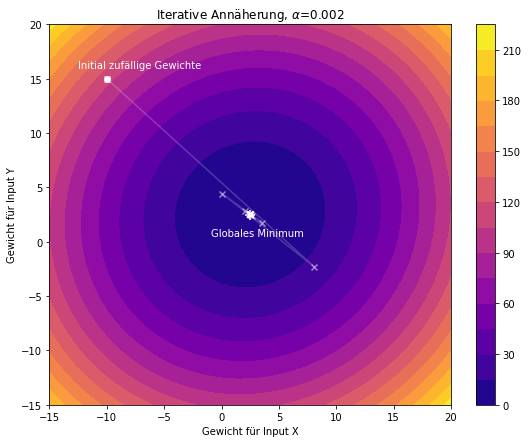

In [269]:
fig = plt.figure(figsize=(9,7))
plt.contourf(w1_space,w2_space,error_surface, cmap=cm.plasma,levels=20)
plt.colorbar()

plt.scatter(w_real[0],w_real[1], marker="+",c="w",s=100) # Global Minimum

plt.text(w_history[0][0]-2.5,w_history[0][1]+1,"Initial zufällige Gewichte",c="w")
plt.text(-0.9,.5,"Globales Minimum",c="w")
#plt.text(w_history[0][0]-2.5,w_history[0][1]-1.5,"Gradienten [-9049,8660]",c="w")
plt.scatter(w_history[:1,:1],w_history[:1,1:],marker="8",c="w")
plt.scatter(w_history[:,:1],w_history[:,1:],marker="x",c="w",alpha=.5)
plt.plot(w_history[:,:1],w_history[:,1:],c="w",alpha=.2)
plt.xlabel("Gewicht für Input X")
plt.ylabel("Gewicht für Input Y")
plt.title("Iterative Näherung an das Globale Minimum mittels GD")
plt.title(r'Iterative Annäherung, $\alpha$=0.002')
plt.show()

Das Gradientenverfahren beginnt an einer beliebigen Stelle und findet über den steilsten auff geradem Weg en tiefsten Punkt und damit die Gewichte, die das zugrundeliegende Muster der Daten, welches uns die Instanzen *gezeigt* haben. 

## Was, wenn wir Fehlerdistribution nicht so angenehm Kreisrund ist?

Fehlerdistributionen sind selten so perfekt und einfach wie oben. Und schon Distributionen die nur ein bisschen komplizierter sind können Probleme bereiten.

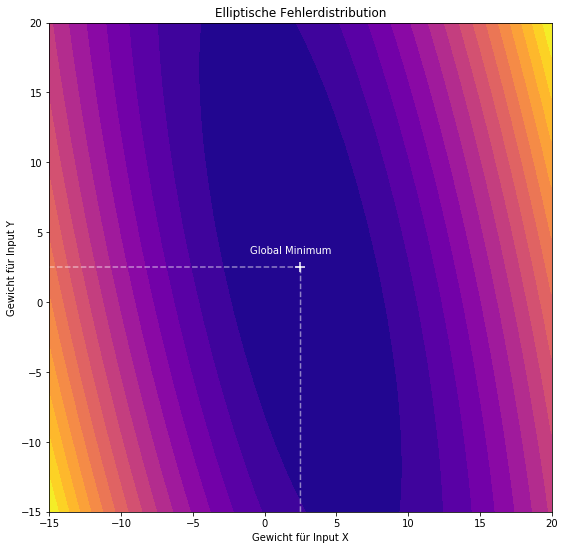

In [270]:
# what if normalized?
x_v2 = np.array([np.random.uniform(-5,1,(1000,)),np.random.uniform(-1.5,0,(1000,))]).T
y_v2 = np.sum(x_v2*2.5,axis=1).reshape(-1,1)
y_v2 += 0.4*np.random.uniform(-1,1,(1000,1))

error_surface_v2 = []
w1_space = np.linspace(-15,20)
w2_space = np.linspace(-15,20)

for w2 in w2_space:
    for w1 in w1_space:
        loss = np.mean(((w1*x_v2[:,:1]+w2*x_v2[:,1:])-y_v2)**2)
        error_surface_v2.append(loss)
        
error_surface_v2 = np.array(error_surface_v2).reshape(50,50)


fig = plt.figure(figsize=(9,9))
plt.contourf(w1_space,w2_space,error_surface_v2, cmap=cm.plasma,levels=20)
plt.scatter(2.5,2.5, marker="+",c="w",s=100)
plt.text(-1,3.5,"Global Minimum",c="w")
plt.plot([-15,2.5],[2.5,2.5],ls="--",c="w",alpha=0.5)
plt.plot([2.5,2.51],[-15,2.51],ls="--",c="w",alpha=0.5)
plt.xlabel("Gewicht für Input X")
plt.ylabel("Gewicht für Input Y")
plt.title("Elliptische Fehlerdistribution")

plt.show()

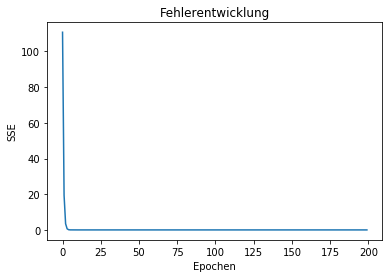

In [282]:
w_v2, error_history_v2, w_history_v2 = gradient_descent(x_v2,np.array([-10,15]),y_v2,lr=0.000135)

plt.title("Fehlerentwicklung")
plt.xlabel("Epochen")
plt.ylabel("SSE")
plt.plot(error_history)
plt.show()

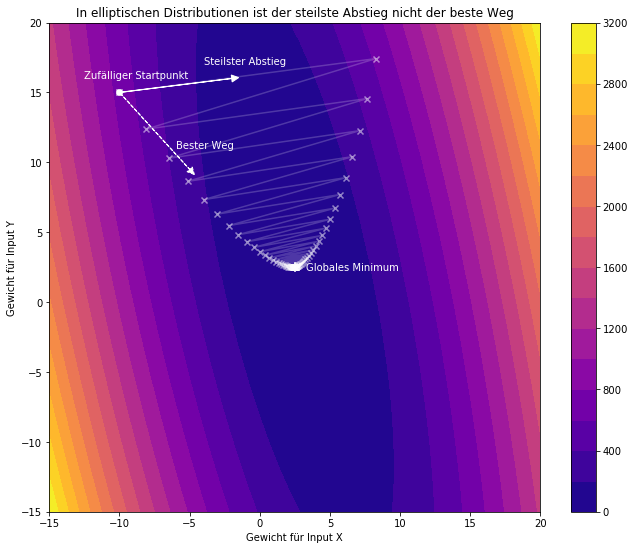

In [283]:
fig = plt.figure(figsize=(11,9))
plt.contourf(w1_space,w2_space,error_surface_v2, cmap=cm.plasma,levels=20)
plt.colorbar()

plt.scatter(2.5,2.5, marker="+",c="w",s=100) # Global Minimum

plt.text(w_history_v2[0][0]-2.5,w_history_v2[0][1]+1,"Zufälliger Startpunkt",c="w")
plt.text(3.3,2.3,"Globales Minimum",c="w")
plt.scatter(w_history_v2[:1,:1],w_history_v2[:1,1:],marker="8",c="w")
plt.scatter(w_history_v2[:,:1],w_history_v2[:,1:],marker="x",c="w",alpha=.5)
plt.plot(w_history_v2[:,:1],w_history_v2[:,1:],c="w",alpha=.2)

plt.text(-4,17,"Steilster Abstieg",c="w")
plt.arrow(-10,15,8,1,head_width=0.5, head_length=0.5,color="white")

plt.text(-6,11,"Bester Weg",c="w")
plt.arrow(-10,15,5,-5.5,head_width=0.5, head_length=0.5,color="white",ls="--")
plt.xlabel("Gewicht für Input X")
plt.ylabel("Gewicht für Input Y")
plt.title("In elliptischen Distributionen ist der steilste Abstieg nicht der beste Weg")
plt.show()

Der steilste Abstig des Gradientenverfahrens zeigt in dieser elliptischen Distribution nicht auf das globale Minimum. Stattdessen zeigt es ein Stück weg davon. Das Problem bleibt zwar lösbar, der eingeschlagene Lösungsweg (die "gelaufene" Distanz) bis zum Ziel ist aber deutlich höher durch das Zick-Zack Muster, als sie sein müsste.

## Momentum

Um diesem Problem entgegenzuwirken können wir das Gradientenverfahren mit einer Erweiterung ausstatten, dem sogenannten Momentum. Anstatt den jeweiligen Gradienten des zu optimierenden Gewichtes (multipliziert mider Learning Rate $\alpha$) von unserem aktuellen Gewicht abzuziehen, fügen wir einen Momentum Wert ein. Dadurch berücksichtigen wir den Gradienten der vorherigen Epoche.<br>

**Vanilla Gradient Descent:**<br>
$w_{i} := w_{i}-\alpha\frac{\partial}{\partial{w_{i}}}r(x)$<br><br>
**Gradient Descent mit Momentum**<br>
$w_{i} := w_{i}-\alpha\frac{\partial}{\partial{w_{i}}}r(x)+\gamma\upsilon_{t}$<br>

Wobei $\upsilon_{t}$ die Anpassung des Gewichts in der letzten Epoche ist (häufig *velocity* genannt) und $\gamma$ ein konstanter Term (bspw. 0.2), das Momentum, der als Hyperparameter die Intensität der Auswirkung von $\upsilon_{t}$ steuert.<br><br>
$\upsilon_{t} = \alpha\frac{\partial}{\partial{w_{i}}}r(x)+\gamma\upsilon_{t-1}$

In [293]:
def gradient_descent_with_momentum(x,w,y,epochs=500,lr=0.000001,momentum=0.2):
    #Für Plots speichern wir alle "zwischendrin" Fehler und Gewichte
    w_history, error_history = [w],[]
    last_velocity = [0,0]
    times = []
    # Mehrere Epochen trainieren
    for _ in tqdm(range(epochs)):
        # Der aktuelle Fehler und das aktuelle Gewicht werden gespeichert
        error_history.append(sse(x,w,y))
        w_history.append(w)
        w_update = []
        # Für jedes einzelne Gewicht
        for i in range(len(w)):
            gradient = np.sum(2*x[:,i:i+1]*(np.dot(x,w).reshape(-1,1)-y))
            velocity = (momentum*last_velocity[i])-(lr * gradient)
            w_update.append(w[i]+velocity)
            last_velocity[i] = velocity

        # Die alten Gewichte werden durch die neuen ersetzt
        w = np.array(w_update)

    # Optimierte Gewichte und "zwischendrin" Fehler und Gewichte zurückgeben
    return w, np.array(error_history), np.squeeze(np.array(w_history)),times

Um dieses Problem zu lösen können wir ein sogenanntes Momentum verweden. 

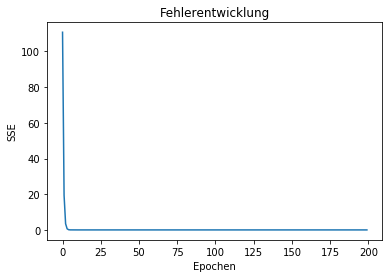

In [294]:
w_momentum, error_history_momentum, w_history_momentum,times = gradient_descent_with_momentum(x_v2,w_random,y_v2,lr=0.00013,momentum=0.25)

plt.title("Fehlerentwicklung")
plt.xlabel("Epochen")
plt.ylabel("SSE")
plt.plot(error_history)
plt.show()

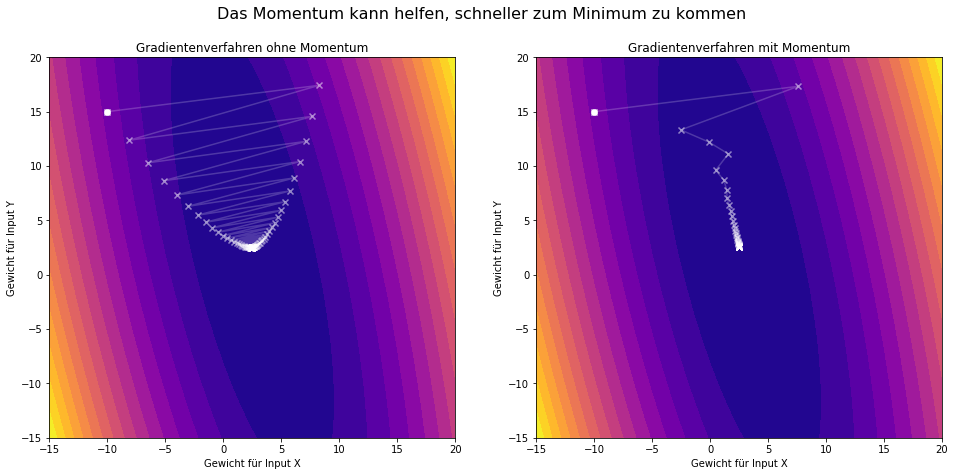

In [287]:
# Plot initialisieren
fig = plt.figure(figsize=(16,7))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

fig.suptitle("Das Momentum kann helfen, schneller zum Minimum zu kommen", fontsize=16)
ax1.contourf(w1_space,w2_space,error_surface_v2, cmap=cm.plasma,levels=20)
ax1.scatter(w_history_v2[:1,:1],w_history_v2[:1,1:],marker="8",c="w")
ax1.scatter(w_history_v2[:,:1],w_history_v2[:,1:],marker="x",c="w",alpha=.5)
ax1.plot(w_history_v2[:,:1],w_history_v2[:,1:],c="w",alpha=.2)

ax1.set_xlabel("Gewicht für Input X")
ax1.set_ylabel("Gewicht für Input Y")
ax1.set_title("Gradientenverfahren ohne Momentum")

ax2.contourf(w1_space,w2_space,error_surface_v2, cmap=cm.plasma,levels=20)
ax2.scatter(w_history_momentum[:1,:1],w_history_momentum[:1,1:],marker="8",c="w")
ax2.scatter(w_history_momentum[:,:1],w_history_momentum[:,1:],marker="x",c="w",alpha=.5)
ax2.plot(w_history_momentum[:,:1],w_history_momentum[:,1:],c="w",alpha=.2)

ax2.set_xlabel("Gewicht für Input X")
ax2.set_ylabel("Gewicht für Input Y")

ax2.set_title("Gradientenverfahren mit Momentum")

fig.show()

Das Momentum sorgt dafür, dass der der Winkel zwischen den nächsten Schritten nicht zu spitz sein darf. Dafür wird die Richtung der vorherigen Epoche miteinbezogen ($\upsilon_{t}$). In diesem Beispiel sorgt diese Optimierung für einen deutlich kürzeren Weg zum globalen Minimum. 